# Template: geodetic "frequentist" mass balance calibration with constant precipitation factor

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib

import statsmodels as stats
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb_geodetic', reset=True)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

/home/lilianschuster/oggm/oggm/cfg.py:381: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2021-06-09 08:54:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-06-09 08:54:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-06-09 08:54:19: oggm.cfg: Multiprocessing: using all available processors (N=8)


## geodetic data from Hugonnet et al. (2021)

In [40]:
use_per_region_files = False
if use_per_region_files:
    # you can download this yourself under https://www.sedoo.fr/theia-publication-products/?uuid=c428c5b9-df8f-4f86-9b75-e04c778e29b9 
    hugonnet_path = '/home/lilianschuster/Schreibtisch/PhD/hugonnet_et_al_2021_per_glacier_time_series/dh_{}_rgi60_pergla_rates.csv'
    rgi = {}
    pd_geodetic_l = {}
    for rgi in ['01','02','03','04','05','06','07','08','09','10','11','12', '13', '14', '15', '16', '17', '18', '19']:
        pd_geodetic_l[rgi] = pd.read_csv(hugonnet_path.format(rgi),  encoding='utf-7', index_col='rgiid')
        # we only want the measurements from 2000 to the end of 2019 
        pd_geodetic_l_20 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2000-01-01_2020-01-01']
        pd_geodetic_l_10_0 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2000-01-01_2010-01-01']
        pd_geodetic_l_10_1 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2010-01-01_2020-01-01']
        pd_geodetic_l[rgi] = pd.concat([pd_geodetic_l_20, pd_geodetic_l_10_0, pd_geodetic_l_10_1])
        pd_geodetic_l[rgi] = pd_geodetic_l[rgi].sort_values('rgiid')
        # concatenate all geodetic observations together that are reference glaciers with at least 5 msm in time period 2000 to 2019
    pd_geodetic = pd_geodetic_l['01']# [pd_geodetic_l['01'].index.isin(pd_wgms.columns.values)]
    for rgi in ['02','03','04','05','06','07','08','09','10','11','12', '13', '14', '15', '16', '17', '18', '19']:
        sel = pd_geodetic_l[rgi]#[pd_geodetic_l[rgi].index.isin(pd_wgms.columns.values)]
        pd_geodetic = pd.concat([pd_geodetic, sel])
    pd_geodetic.to_csv('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv')
else:
    # we use now the corrected and filled dataset
    pd_geodetic = utils.get_geodetic_mb_dataframe()
    pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']

In [52]:
len(set(pd_geodetic.dropna().index))

210118

In [6]:
pd.read_csv(hugonnet_path.format(rgi),  encoding='utf-7', index_col='rgiid')

,period,area,dhdt,err_dhdt,dvoldt,err_dvoldt,dmdt,err_dmdt,dmdtda,err_dmdtda,perc_area_meas,perc_area_res,valid_obs,valid_obs_py,reg
rgiid,,,,,,,,,,,,,,,
RGI60-19.00001,2000-01-01_2001-01-01,64608000.0,0.0490,2.8692,3166797.0,185376458.0,0.002692,0.157570,0.0417,2.4389,0.996,1.000,0.00,0.00,19
RGI60-19.00001,2000-01-01_2002-01-01,64608000.0,0.0332,1.3097,2145671.0,84614265.0,0.001824,0.071922,0.0282,1.1132,0.996,1.000,0.00,0.00,19
RGI60-19.00001,2000-01-01_2004-01-01,64608000.0,0.0487,0.6026,3143438.0,38935260.0,0.002672,0.033096,0.0414,0.5123,0.996,1.000,1.17,1.16,19
RGI60-19.00001,2000-01-01_2005-01-01,64608000.0,0.0016,0.5340,102991.0,34499998.0,0.000088,0.029325,0.0014,0.4539,0.996,1.000,2.17,2.16,19
RGI60-19.00001,2000-01-01_2010-01-01,64608000.0,-0.0534,0.3199,-3452384.0,20665638.0,-0.002935,0.017567,-0.0454,0.2719,0.996,1.000,4.40,4.20,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-19.02752,2016-01-01_2020-01-01,528000.0,-0.3660,1.4540,-193224.0,768177.0,-0.000164,0.000653,-0.3111,1.2376,0.981,0.981,0.54,0.54,19
RGI60-19.02752,2017-01-01_2018-01-01,528000.0,-0.3551,5.6545,-187504.0,2985716.0,-0.000159,0.002538,-0.3019,4.8068,0.981,0.981,0.31,0.31,19
RGI60-19.02752,2018-01-01_2019-01-01,528000.0,-0.3762,5.7605,-198636.0,3041675.0,-0.000169,0.002585,-0.3198,4.8969,0.981,0.981,0.00,0.00,19


In [134]:
# this is the specific mass balance for every glacier 
pd_geodetic.dmdtda.dropna() *1000 # this is in kg/m2/yr

rgiid
RGI60-01.00001     -12.8
RGI60-01.00002    -229.0
RGI60-01.00003    -797.9
RGI60-01.00004    -407.5
RGI60-01.00005      39.0
                   ...  
RGI60-19.02747    -676.5
RGI60-19.02749    -826.8
RGI60-19.02750    -411.7
RGI60-19.02751   -1836.9
RGI60-19.02752     -38.6
Name: dmdtda, Length: 210120, dtype: float64

- for some few glaciers, there are no geodetic measurements!

## calibration: 

- have to set the hydro_year to 1 (geodetic data corresponds to MB from Jan 2000 to Jan 2020)!!!

In [136]:
cfg.PARAMS['baseline_climate'] = 'CRU' #'ERA5'
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['prcp_scaling_factor'] = 2.5 # if ERA5 use maybe 1.6 ?!

In [143]:
def minimize_bias_geodetic_mu_star(x, gd_mb=None, mb_geodetic=None,
                           h=None, w=None, pf=2.5,
                           ys=np.arange(2000, 2020, 1),
                           ):
    """ calibrates the melt factor (melt_f/mu_star) by getting the bias to zero
    comparing modelled mean specific mass balance between 2000 and 2020 to
    observed geodetic data

    Parameters
    ----------
    x : float
        what is optimised (here the melt_f/mu_star)
    gd_mb: class instance
        instantiated class of Pastmassbalane, this is updated by mu_star
    mb_geodetic: float
         geodetic mass balance between 2000-2020 of the instantiated glacier
    h: np.array
        heights of the instantiated glacier
    w: np.array
        widths of the instantiated glacier
    pf: float
        precipitation scaling factor
        default is 2.5
    ys: np.array
        years for which specific mass balance is computed
        default is 2000--2019

    Returns
    -------
    float
        bias: modeled mass balance mean - reference mean (geodetic)
        if absolute_bias = True:  np.abs(bias) is returned

    """
    gd_mb.mu_star = x

    gd_mb.prcp_fac = pf
    mb_specific = gd_mb.get_specific_mb(heights=h,
                                        widths=w,
                                        year=ys).mean()
    bias_calib = np.mean(mb_specific - mb_geodetic)

    return bias_calib

In [158]:
df = ['RGI60-11.00897']
#df = ['RGI60-11.01450']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]
oggm.core.climate.process_climate_data(gdir)

2021-05-12 10:08:55: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-05-12 10:08:55: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


**important**: 
- we need to set the residual/bias to zero in PastMassBalance


In [159]:
# we use here the default OGGM mass balance model! 
gd_mb = massbalance.PastMassBalance(gdir, mu_star=200, # just set it to any value, this will be calibrated later
                                    bias=0, # set to zero!
                                    check_calib_params=False)
# set the precipitation factor to a constant value of 
gd_mb.prcp_fac = cfg.PARAMS['prcp_scaling_factor'] # just to make sure that the right prcp factor is applied 
# get the geodetic measurements of that glacier
mb_geodetic = pd_geodetic.loc[df].dmdtda.values *1000

# calibration time period
ys = np.arange(2000, 2020)
h, w = gdir.get_inversion_flowline_hw()
# find the optimal melt factor that minimises the bias of the geodetic measurements (2000-2019)
# allow the melt factor to be between 10 and 1000, 
melt_f = scipy.optimize.brentq(minimize_bias_geodetic_mu_star, 10, 1000,  # allow the melt factor to be between 10 and 1000, 
                      xtol = 0.01, args=(gd_mb, mb_geodetic, h, w, cfg.PARAMS['prcp_scaling_factor'],
                                         ys), # which years should be used: normally 2000-2019 (but for some climate datasets there is no 2019 available)
                                    disp=True)
# the mu_star is the melt factor ...                          
print(melt_f)
# you can save the calibrated melt_f/mu_star for the glacier or you can directly do projections, or whatever with the new calibrated mu_star / melt_f


184.32415325809973


## check and validation
**here we only check if the calibration has worked and compare it to the direct glaciological measurements if there are any available for that glacier**

In [160]:
# change in the mass balance model instance the mu_star to the new calibrated mu_star/melt_f
gd_mb.mu_star = melt_f
# compute the specific mass balance for that glacier using the calibrated melt_f
mb_specific = gd_mb.get_specific_mb(heights=h,
                                    widths=w,
                                    year=ys)
np.testing.assert_allclose(mb_geodetic, mb_specific.mean(), rtol=1e-3)

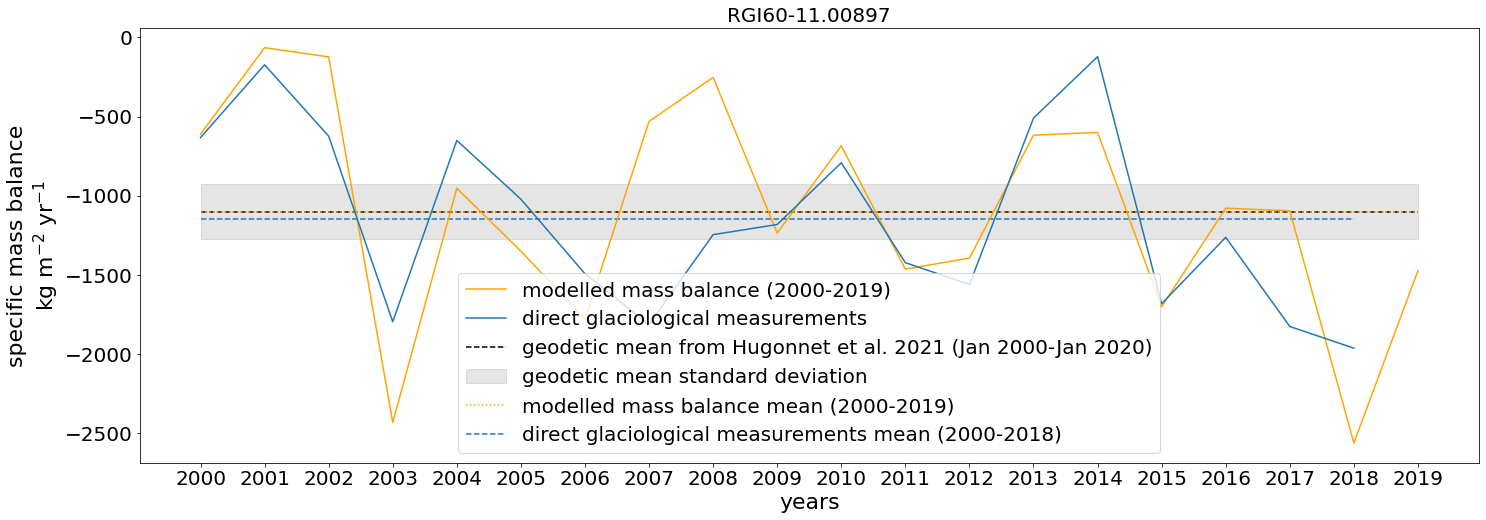

In [161]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(24,8))
plt.hlines(mb_geodetic, label = 'geodetic mean from Hugonnet et al. 2021 (Jan 2000-Jan 2020)', xmin=2000, xmax = 2019,
            ls = '--',
            color = 'black')

# just for visualization: standard deviation from the Hugonnet data 
mb_geodetic_std = pd_geodetic.loc[df].err_dmdtda.values *1000
plt.fill_between(x=ys,
                 y1=np.repeat(mb_geodetic, len(ys))-mb_geodetic_std,
                 y2=np.repeat(mb_geodetic, len(ys))+mb_geodetic_std,
                 alpha = 0.1, color = 'black', label = 'geodetic mean standard deviation')

plt.plot(ys, mb_specific, label='modelled mass balance (2000-2019)', color='orange')
plt.hlines(mb_specific.mean(), label = 'modelled mass balance mean (2000-2019)',xmin=2000, xmax = 2019,
           ls = ':', color = 'orange')



try:
    plt.plot(ys[:-1], gdir.get_ref_mb_data()['ANNUAL_BALANCE'].loc[2000:],label = 'direct glaciological measurements')
    plt.hlines(gdir.get_ref_mb_data()['ANNUAL_BALANCE'].loc[2000:].values.mean(),
              xmin=2000, xmax = gdir.get_ref_mb_data()['ANNUAL_BALANCE'].index[-1],
                label = 'direct glaciological measurements mean (2000-2018)', ls = '--')

except:
    pass

plt.xlabel('years')
plt.ylabel('specific mass balance\nkg m$^{-2}$ yr$^{-1}$')
plt.xticks(ys)
plt.legend();
plt.title(gdir.rgi_id);

- if you want to use the new calibration to do projections and use e.g. `run_from_climate_data`, we need to adapt the function because the new calibrated `mu_star` has to be included
(I use my own set of functions because I had to change more stuff)
    - **but maybe you find a better way that OGGM uses directly the internal new calibrated melt_f** (in my case I wanted to change other stuff like the precipitation factor, so this was not possible)
- similar as in `run_from_climate_data_TIModel`, but you only need to change the mu_star/melt_f and not precipitation factor, so you won't need to defn-> https://github.com/OGGM/massbalance-sandbox/blob/master/MBsandbox/wip/projections_bayescalibration.py#L63
- for the projections I use then `inversion_and_run_from_climate_with_bayes_mb_params` here (some bayesian calibration stuff included here, but it might help to see how to do the projections: -> https://github.com/OGGM/massbalance-sandbox/blob/15a26ec549e41c0d5506237f5fb2fb5d0bae5a07/MBsandbox/wip/projections_bayescalibration.py#L1104